In [1]:
import os
import time
import random
import requests
import import_ipynb
import importlib
import numpy as np
import Cicero as Cic
import pandas as pnd
import Glossa as glos
import BggHelper as BH
import BggDbGetter as BDG
import BggDbScraper as BDS
from langdetect import detect
from tqdm.notebook import tqdm
from boardgamegeek import BoardGameGeek

importing Jupyter notebook from Cicero.ipynb
importing Jupyter notebook from BggHelper.ipynb
importing Jupyter notebook from BggDbGetter.ipynb
importing Jupyter notebook from BggDbScraper.ipynb
importing Jupyter notebook from Glossa.ipynb


# Step 1

Access BBG API's to download game and user preferences data.
Define criterion used for setting the parameters that drive the download in termis of the variables defining the dataset, such collecting games only for a specified period or a specified set of categories. The wider the game collection, the better.

In [2]:
helper = BH.BggHelper()
new_df = helper.bgg_start(get=False, scrape=False)

#### Dataframe reading

In [3]:
df = pnd.read_csv("BGG_sampled.csv")
df.shape
dfh = df

In [4]:
df.columns

Index(['Unnamed: 0', 'boardgame_rank', 'id', 'families', 'categories',
       'mechanics', 'designers', 'artists', 'publishers', 'description',
       'yearpublished', 'minplayers', 'maxplayers', 'playingtime', 'minage',
       'name', 'usersrated', 'average', 'bayesaverage', 'stddev', 'owned',
       'numweights', 'averageweight', 'ranks'],
      dtype='object')

In [5]:
gls = glos.Glossa(dfh, "en")
cicero = Cic.Cicero(gls)

In [6]:
cicero = cicero.clean_lemming("description")

Glossa.ipynb:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "import pandas as pnd\n",


Glossa.ipynb:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "from nltk.stem import LancasterStemmer, WordNetLemmatizer\n",
Glossa.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "from nltk.corpus import stopwords\n",


In [7]:
cicero = cicero.clean_lemming("categories")

In [8]:
#cicero = cicero.eng_lemming("name")
#cicero = cicero.eng_lemming("publishers")

In [9]:
cicero = cicero.clean_lemming("families")

# Step 2
Pre-process game text (title and description) in order to define the terms to include in the variables to be observed, eventually using a word embedding model to normalize and/or expand the terminology extracted from the game description.

## Follow this url:
### https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92

There is the question of HOW to train the word embedding model and how to calculate the similarity between most and least successful games. <br>
Maybe adding a dataset column is not such a bad idea, keeps it clean and of easy computation. <br>
Glossa and Cicero work relatively well, now a new library for this analysis is needed. Might call it Pitagora. Don't know

#### Need to create a column in the dataframe containing all the important words in the row. <br> This takes into account Name, description, mechanics, families and publishers

In [10]:
model = cicero.word2vec_train(["description", "mechanics", "categories", "families", "publishers"])

In [21]:
cicero.get_df()["name"]

0                                              Gloomhaven
1                                       Terraforming Mars
2                                       Brass: Birmingham
3                      Twilight Imperium (Fourth Edition)
4                                    Star Wars: Rebellion
                              ...                        
6859                      The Hobbit: The Defeat of Smaug
6860    The Lord of the Rings: The Fellowship of the Ring
6861                        Who Wants to Be a Millionaire
6862                                          In a Pickle
6863                           The Oregon Trail Card Game
Name: name, Length: 6864, dtype: object

In [22]:
model["Terraforming Mars"]

/home/tore/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.00924538, -0.01012653, -0.01535632, -0.00114066, -0.00335895,
       -0.01334199,  0.02720284,  0.01267164,  0.04537748,  0.00330736,
       -0.01241728,  0.00067292, -0.00152644,  0.00525018,  0.01251437,
       -0.02823836, -0.02795514,  0.00396173,  0.01612429,  0.00320877,
       -0.0092906 , -0.0181068 , -0.00412476, -0.01037333,  0.01542005,
        0.01066408,  0.01191413, -0.01221556, -0.05841997, -0.0287025 ,
       -0.0135936 , -0.00806321,  0.00885616,  0.01229679,  0.01196987,
       -0.02894597, -0.02055464,  0.02208876, -0.01109718, -0.03999105,
       -0.01156571,  0.01221566, -0.02969262, -0.06421204, -0.01559058,
        0.02136141, -0.0140701 , -0.04226363,  0.03803984,  0.0337416 ,
        0.02203387,  0.03580365,  0.02012222,  0.03525194, -0.02000244,
       -0.00387121, -0.03476477, -0.01339028,  0.02926917, -0.00622564,
       -0.00736795,  0.00966154,  0.01528964, -0.01573504,  0.05645765,
       -0.01568481,  0.00811696,  0.01000677,  0.0021259 ,  0.00

# ERRORE: Il nome del gioco deve essere inserito come unica stringa

In [34]:
models = []
#models = np.append(models, model["Terraforming Mars"])
#print(model["terraforming mars"])
for index, row in tqdm(cicero.get_df().iterrows()):
    models.append((row["name"], model[row["name"]], model[row["name"]].shape[0]))

/home/tore/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [35]:
models

[('Gloomhaven',
  array([-8.5081521e-04, -1.8509524e-02, -5.9870617e-03,  2.3224391e-02,
         -9.8090330e-03, -2.7778851e-02,  2.6482766e-02, -1.7923944e-03,
          5.5653200e-02,  2.0358185e-03, -1.5818822e-03, -5.5381199e-03,
          2.0413923e-03,  2.4076652e-02,  1.9343626e-02, -1.9644968e-02,
         -2.6809311e-02,  1.3622848e-02,  1.6445111e-03,  1.3449032e-02,
         -2.7423729e-03, -1.5739528e-02, -2.1358239e-03, -8.1098191e-03,
         -3.8901269e-03,  3.0253749e-02,  5.9124241e-03, -3.7692145e-03,
         -4.6140347e-02, -2.4668541e-02, -4.1540451e-03, -1.3113560e-02,
         -3.4728611e-03,  1.1113412e-03,  3.0544039e-04, -1.9739076e-02,
         -2.4961838e-02, -2.2879598e-04, -9.5829004e-03, -2.5290307e-02,
         -3.9153122e-03,  2.2547187e-02, -1.9881442e-02, -8.0643617e-02,
          6.1538751e-04,  4.3464083e-02, -8.2273241e-03, -5.6317765e-02,
          3.3801980e-02,  2.0865118e-02,  1.4433479e-02,  2.8473143e-02,
          1.2094652e-02,  2.6304841

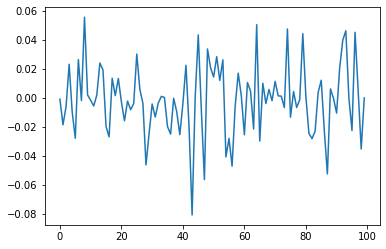

In [45]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
plt.plot(models[0][1])

## Step 3
Perform a correlation analysis of the variables. On top of this, try to design and implement a model for predicting the "subjective" variable values starting from the "objective" variables. Optionally, define a recommendation system for games.

## Variables to be observed:

<table style="width:100%">
  <tr>
    <th>Objective</th>
    <th>Subjective</th>
  </tr>
  <tr>
    <td>Name</td>
    <td>User rating</td>
  </tr>
  <tr>
    <td>Description</td>
    <td>Average</td>
  </tr>
  <tr>
    <td>Categories</td>
    <td>Average Weight</td>
  </tr>
  <tr>
    <td>Families</td>
    <td>Owned</td>
  </tr>
  <tr>
    <td>Publishers</td>
    <td></td>
  </tr>
  <tr>
    <td>Mechanics</td>
    <td></td>
  </tr>
  <tr>
    <td>Rank</td>
    <td></td>
  </tr>
</table>

## Step 4
Include in the paper a report describing the output of Step 3